# Digital Twin Network

In [1]:
import os
os.chdir("D:/my_py_packages/supplyseer")

In [2]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from src.supplyseer.experimental.exotic_supplychain.supplychaingraphs import SupplyChainNetwork, SupplyChainNode

### Designing a Multi-Echelon Network

In [4]:
WAREHOUSES = ["A", "B", ]
STORES = np.arange(1, 15, 1).tolist()


How many days do you want to create simulations for?

Let's put it at 365 days a full year

In [5]:
N = 365
index = pd.date_range(start='2023-01-01', periods=N, freq='D')

### Data preparation
Prepare your dataframes for each location

In [6]:
nodes = {}
edges = {}

for wh in WAREHOUSES:
    forecasted_demand = np.random.poisson(np.random.poisson(12), size=N)
    # Example input data
    warehouse_df = pd.DataFrame({
        'stock_level': [1000] * N,
        'forecast_demand': forecasted_demand,
        'actual_sales': forecasted_demand - 1,
        'reorder_point': [450] * N,
        'target_stock': [700] * N,
        'replenishment_lead_time': [2] * N  # 2 days to receive new stock
    }, index=index)

    nodes["Warehouse "+wh] = SupplyChainNode("Warehouse "+wh, warehouse_df, verbose=False)

    for store in STORES:
        if wh == "A":
            if store in np.arange(1, 10, 1).tolist():
                store_name = "Store_"+str(store)
                wh_store_combination = ("Warehouse "+wh, store_name)
                forecasted_demand2 = np.random.poisson(np.random.poisson(12), size=N)

                retail_store_df = pd.DataFrame({
                'stock_level': [np.random.poisson(60)] * N,
                'forecast_demand': forecasted_demand2,
                'actual_sales': forecasted_demand2 - 1,
                'reorder_point': [20] * N,
                'target_stock': [35] * N,
                'replenishment_lead_time': [2] * N
                }, index=index)

                nodes[store_name] = SupplyChainNode(store_name, retail_store_df, verbose=False)
                edges[wh_store_combination] = {'potential': np.random.beta(2, 4), 'max_flow_rate': np.random.poisson(50)}
        
        if wh == "B":
            if store in np.arange(10, 13, 1).tolist():
                store_name = "Store_"+str(store)
                wh_store_combination = ("Warehouse "+wh, store_name)
                forecasted_demand2 = np.random.poisson(np.random.poisson(12), size=N)
                retail_store_df = pd.DataFrame({
                'stock_level': [np.random.poisson(70)] * N,
                'forecast_demand': forecasted_demand2,
                'actual_sales': forecasted_demand2 - 1,
                'reorder_point': [15] * N,
                'target_stock': [50] * N,
                'replenishment_lead_time': [2] * N
                }, index=index)

                nodes[store_name] = SupplyChainNode(store_name, retail_store_df, verbose=False)   
                edges[wh_store_combination] = {'potential': np.random.beta(2, 4), 'max_flow_rate': np.random.poisson(50)}

        if wh == "C":
            if store in np.arange(13, 15, 1).tolist():
                store_name = "Store_"+str(store)
                wh_store_combination = ("Warehouse "+wh, store_name)
                forecasted_demand2 = np.random.poisson(np.random.poisson(12), size=N)
                retail_store_df = pd.DataFrame({
                'stock_level': [np.random.poisson(50)] * N,
                'forecast_demand': forecasted_demand2,
                'actual_sales': forecasted_demand2 - 1,
                'reorder_point': [20] * N,
                'target_stock': [45] * N,
                'replenishment_lead_time': [2] * N
                }, index=index)

                nodes[store_name] = SupplyChainNode(store_name, retail_store_df, verbose=False)   
                edges[wh_store_combination] = {'potential': np.random.beta(2, 4), 'max_flow_rate': np.random.poisson(50)}      

## Simulation time
We will be approaching the Supply Chain Digital Twin Network with a traditional policy:
* Classic Reorder Trigger Points
    * Safety stock thresholds as reorder points
    * 100% control
    * Need safety level analysis pre-simulation

<br>
And then we will use a Physics inspired policy called 'diffusion' <br>

* Diffusion and potential fields
    * The system naturally balances inventory across nodes based on local conditions
    * Responds automatically to changes in demand or supply
    * Can handle disruptions by redistributing inventory through alternative paths
    * In reality, this is expensive to constantly have a flow of reorders

<br>
Last one is 'hybrid' which combines traditional policy with the Physics approach <br>

* Hybrid
    * Analogy: Semi-permeable membranes
    * Warehouses act as regulated reservoirs (controlled release)
    * Stores operate through selective diffusion
    * Flow rates are damped to prevent turbulence
    * Good for mixed node types (large warehouses and small stores)

In [7]:

network = SupplyChainNetwork(nodes, edges, verbose=False)

### Classical Policy

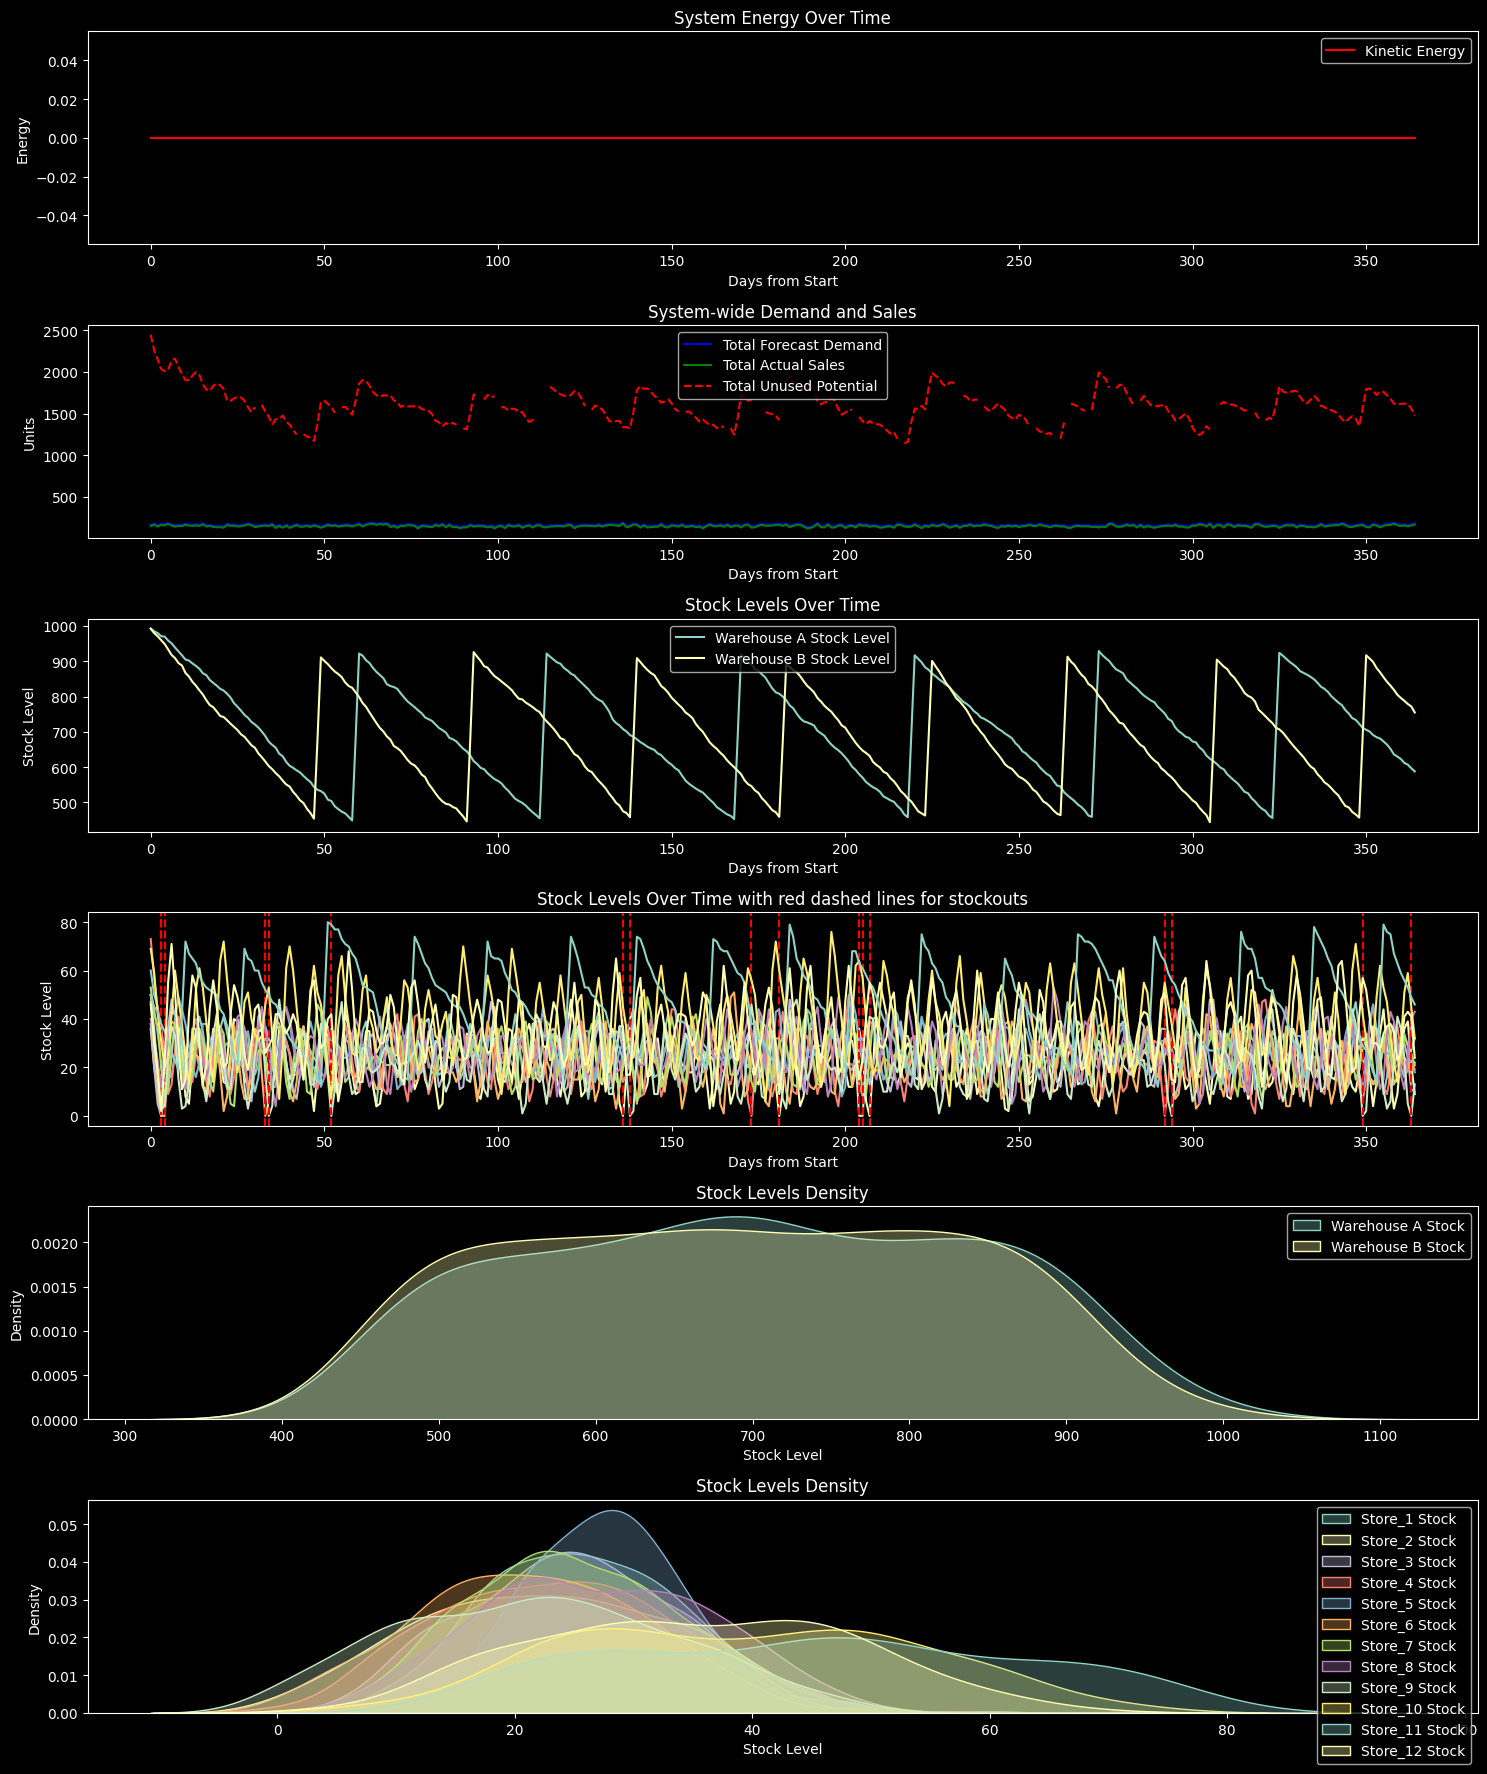

In [8]:
network.simulate_flow()

### Diffusion

In [9]:
network = SupplyChainNetwork(nodes, edges, flow_mode="diffusion", verbose=False)

D:\my_py_packages\supplyseer\src\supplyseer\experimental\exotic_supplychain\supplychaingraphs.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '266.2144192026089' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.results.iloc[current_timestamp_idx, self.results.columns.get_loc('ordered_amount')] = order_amount
D:\my_py_packages\supplyseer\src\supplyseer\experimental\exotic_supplychain\supplychaingraphs.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '240.85691822148533' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.results.iloc[current_timestamp_idx, self.results.columns.get_loc('ordered_amount')] = order_amount


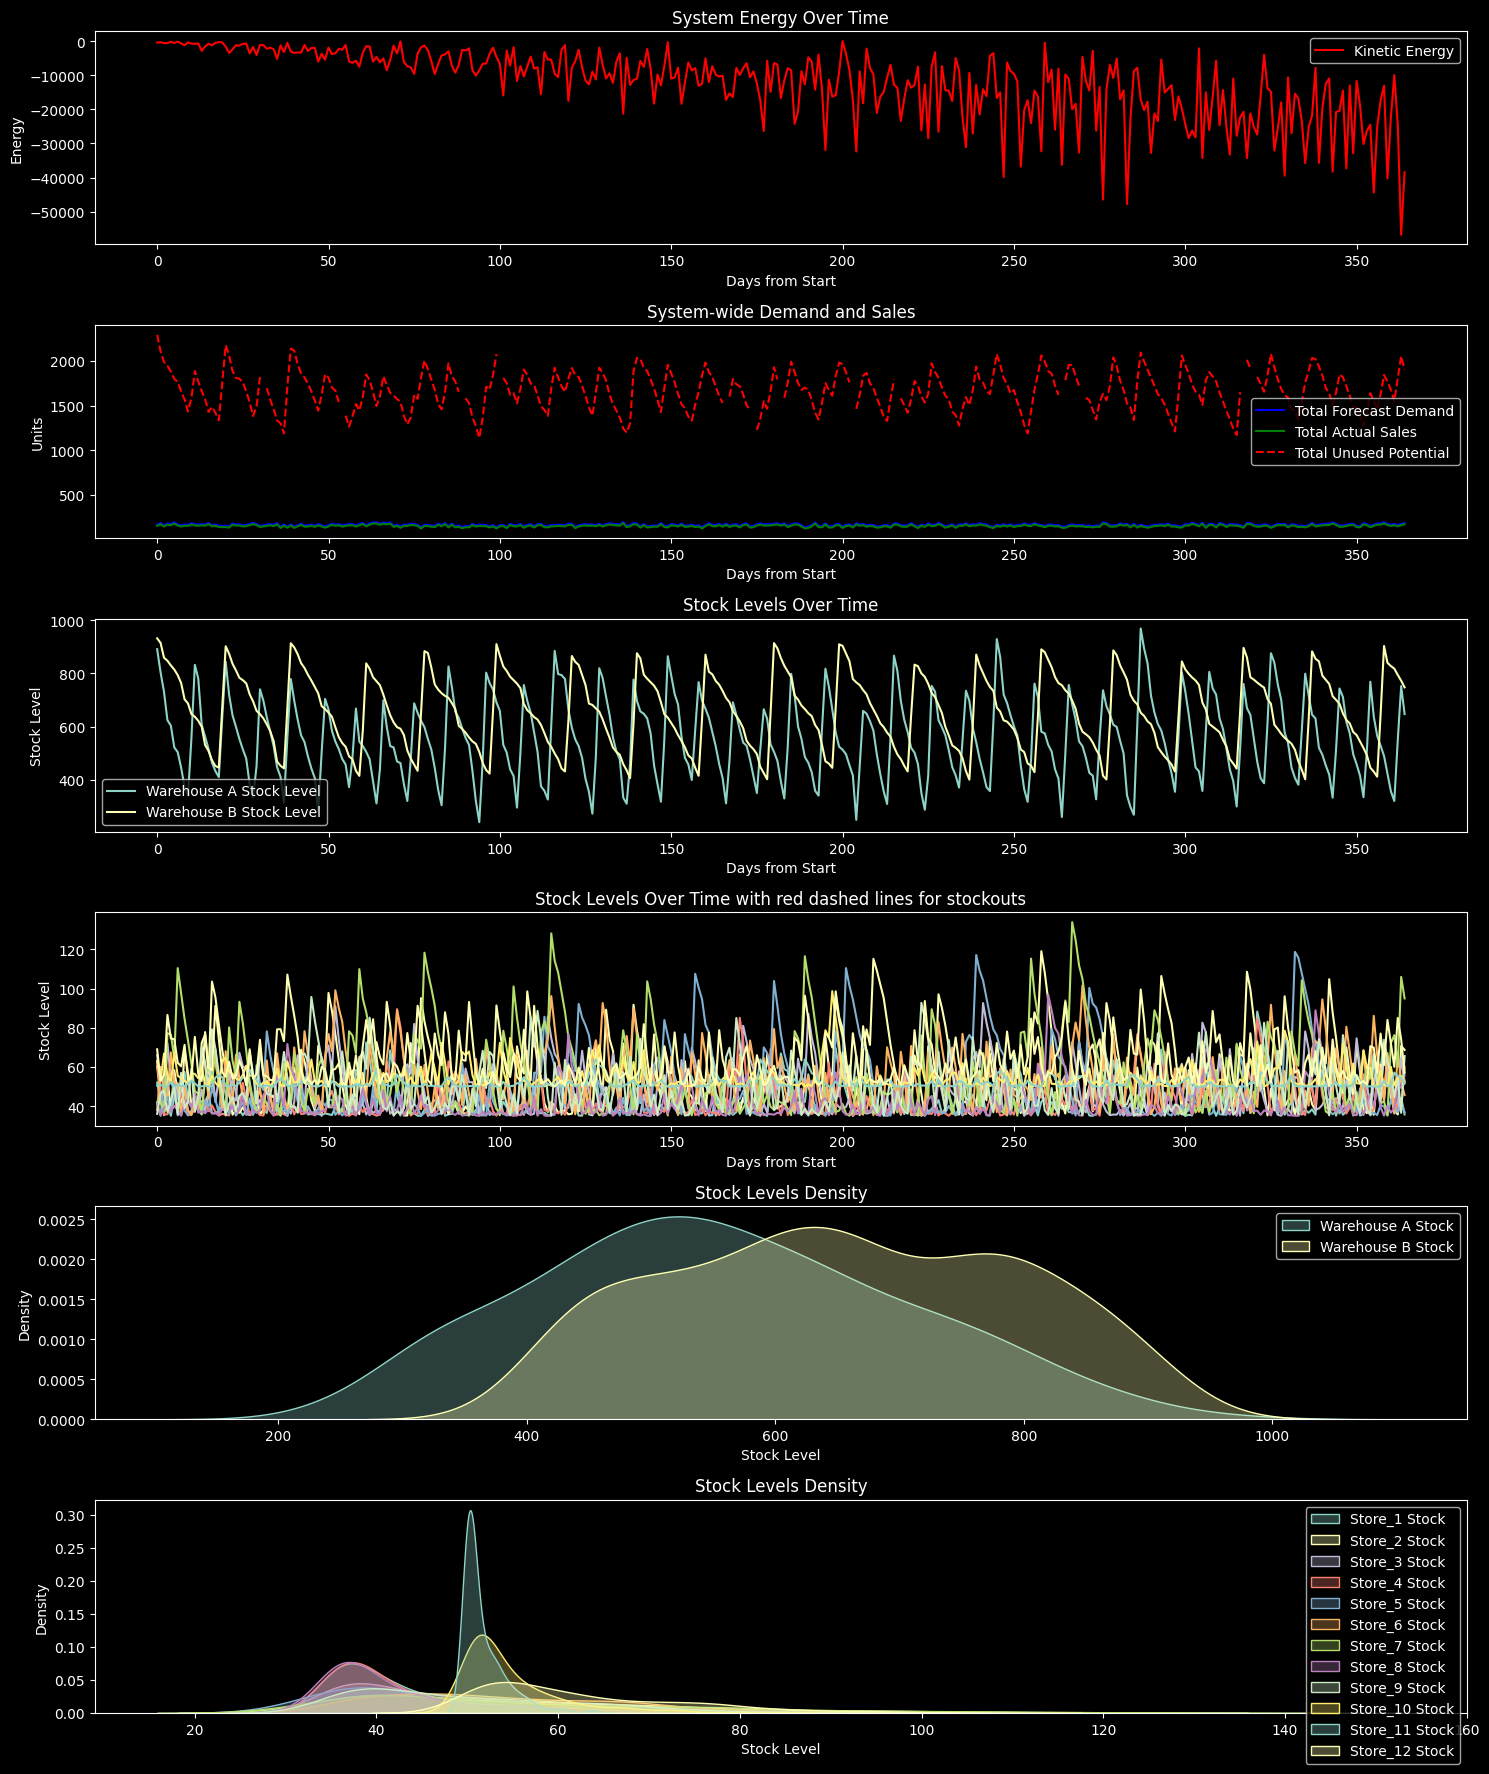

In [10]:
network.simulate_flow()

### Hybrid

In [11]:
network = SupplyChainNetwork(nodes, edges, flow_mode="hybrid", verbose=False)

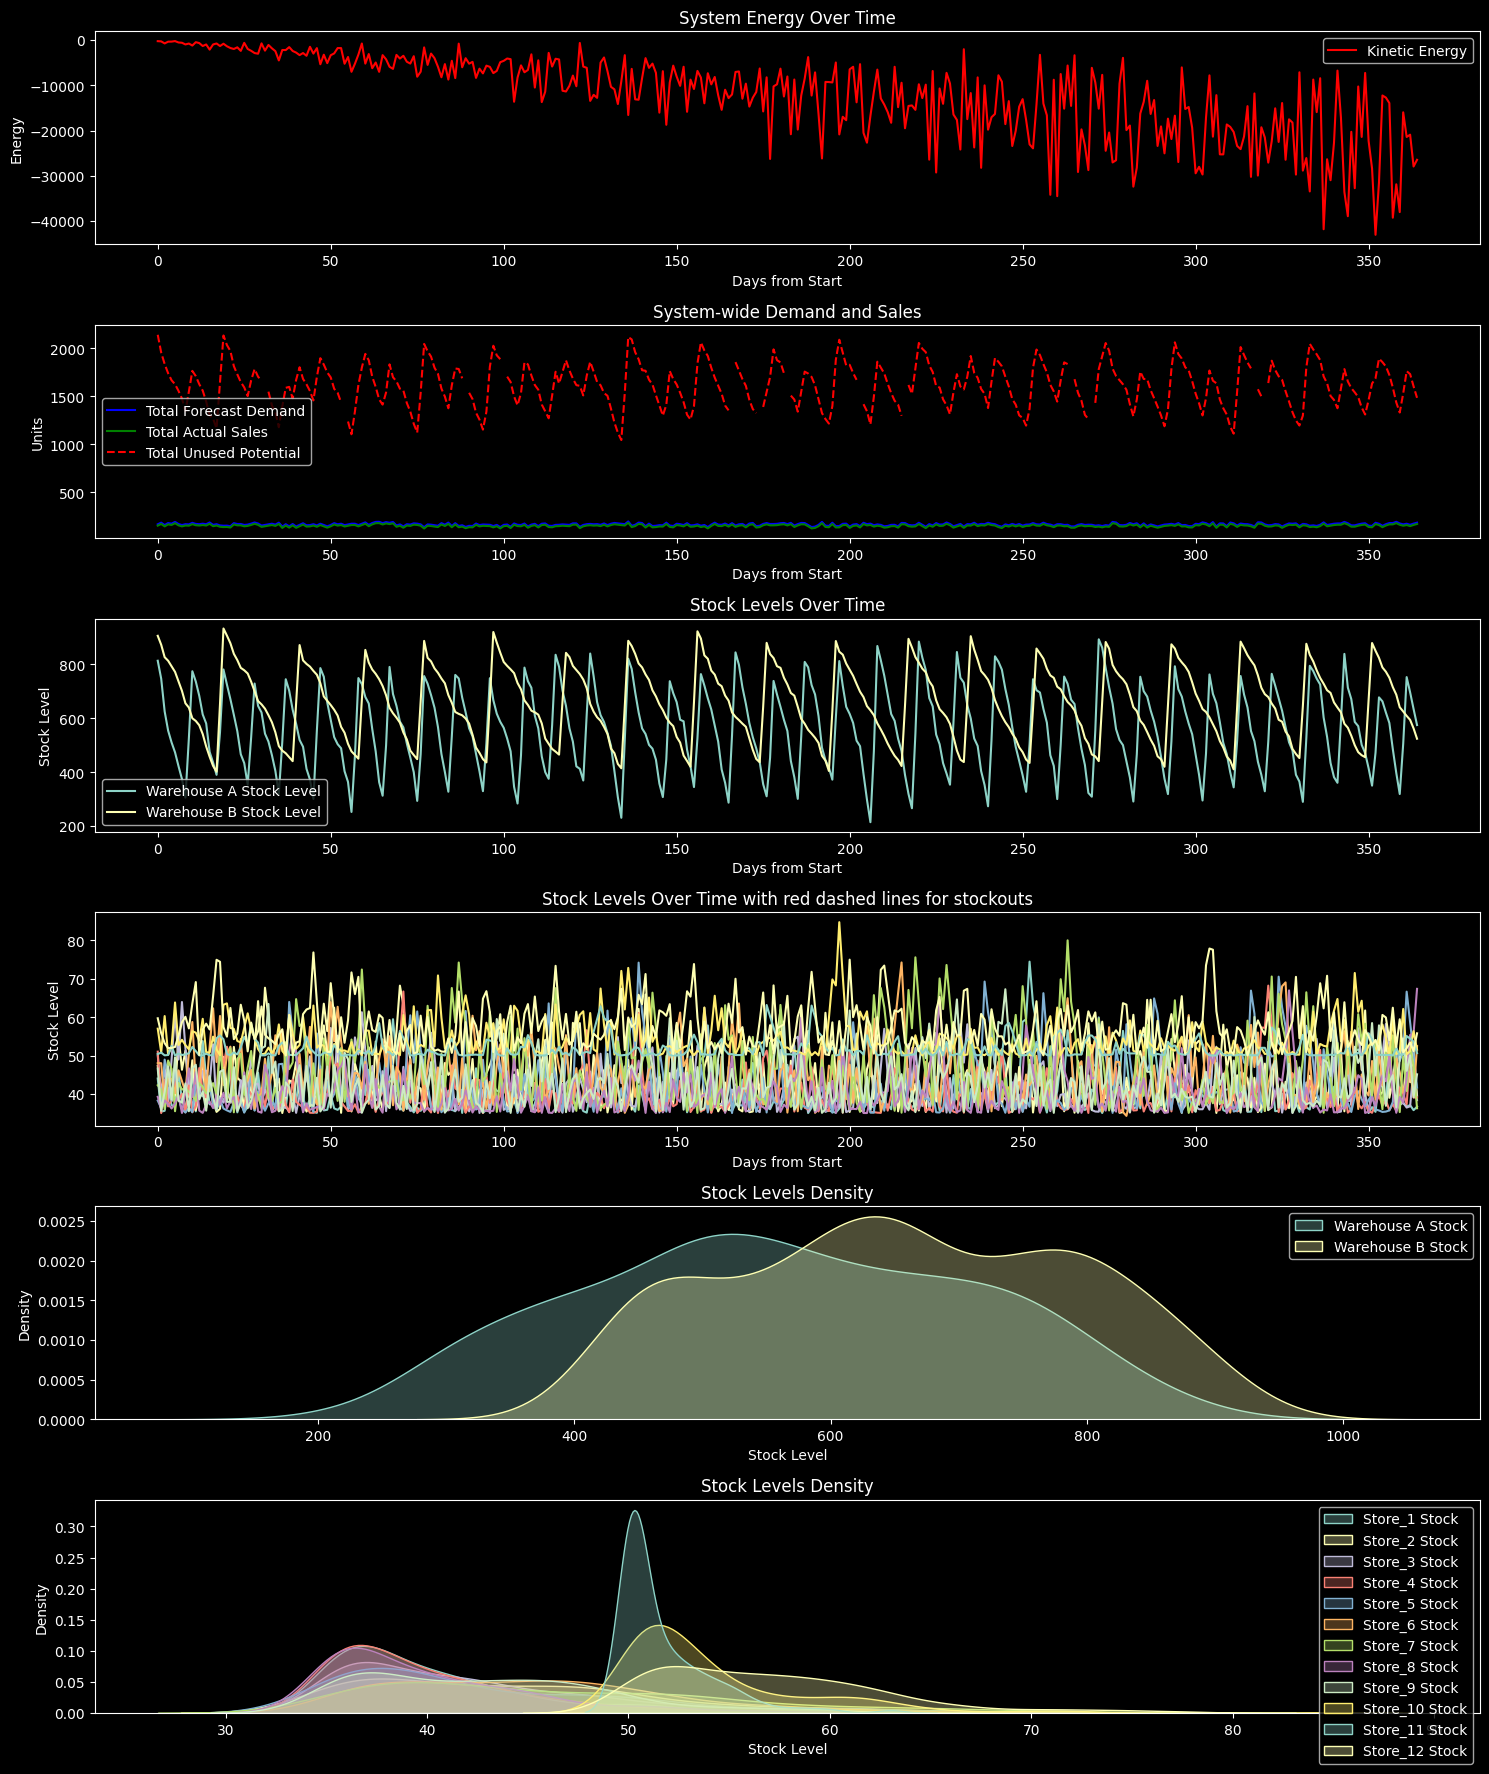

In [12]:
network.simulate_flow()

### Analysis by grabbing the metrics

In [13]:
network.get_filtered_metrics("Store_11").head(10)


,forecast_demand,actual_sales,unused_potential,total_stock,stockout,Store_11_stock,Store_11_forecast,Store_11_sales,Store_11_unused
2023-01-01,5,4,46.394088,50.394088,0,50.394088,5,4,46.394088
2023-01-02,6,5,45.753994,50.753994,0,50.753994,6,5,45.753994
2023-01-03,3,2,48.042584,50.042584,0,50.042584,3,2,48.042584
2023-01-04,6,5,45.134374,50.134374,0,50.134374,6,5,45.134374
2023-01-05,4,3,49.494279,52.494279,0,52.494279,4,3,49.494279
2023-01-06,5,4,46.017681,50.017681,0,50.017681,5,4,46.017681
2023-01-07,6,5,45.501931,50.501931,0,50.501931,6,5,45.501931
2023-01-08,4,3,47.13331,50.13331,0,50.13331,4,3,47.13331
2023-01-09,5,4,46.299306,50.299306,0,50.299306,5,4,46.299306
2023-01-10,5,4,46.596046,50.596046,0,50.596046,5,4,46.596046


## Network Structure

This tells us a few things. <br>

* Potential
    * Capacity of flow between warehouses and stores
* Diffusion Flow
    

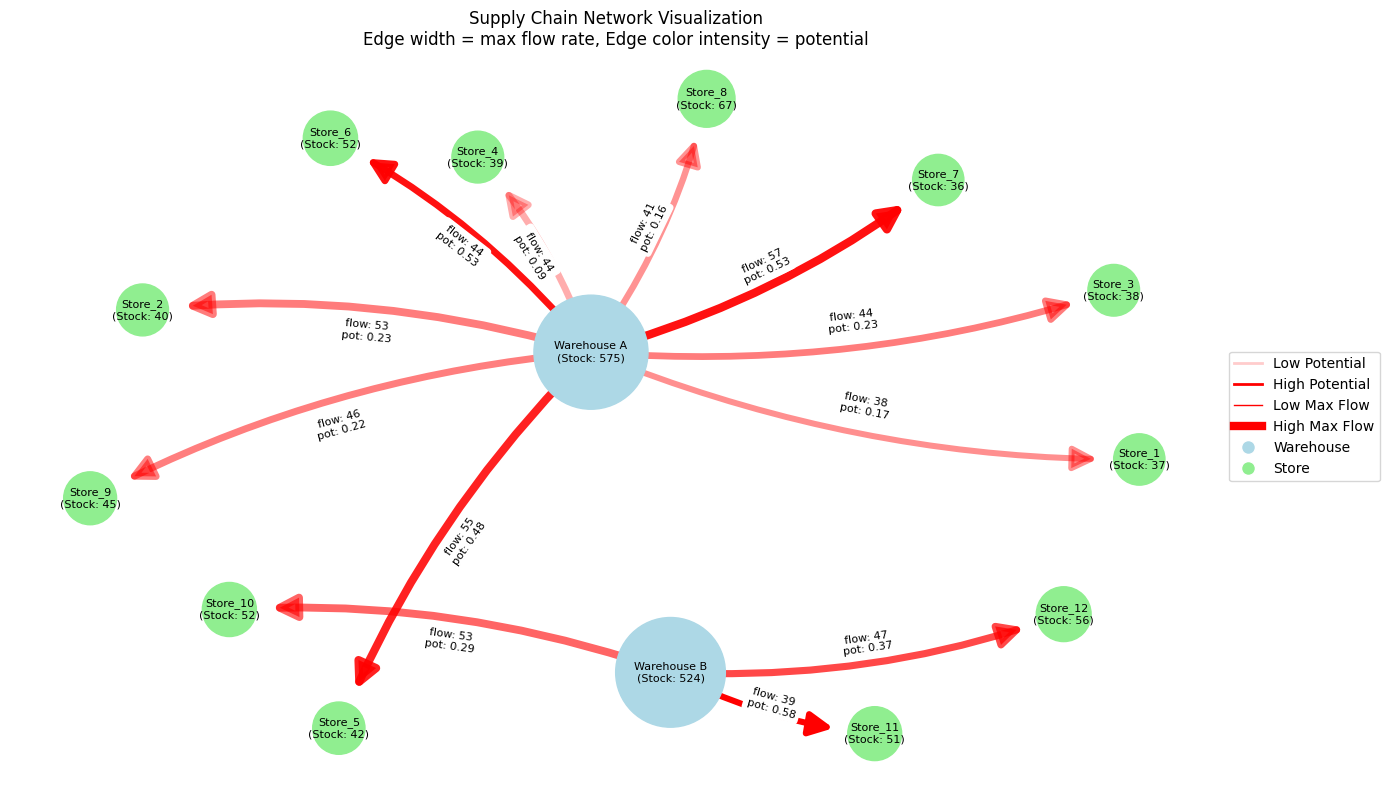

In [14]:
plt.style.use("default")
network.visualize_network()